# Implementing a CNN in TensorFlow & Keras using Dogs and Cats Dataset

Source: 
* https://www.tensorflow.org/tutorials/images/classification
* https://learnopencv.com/implementing-cnn-tensorflow-keras/


Table of Content

1. Load Dogs and Cats dataset
2. Dataset Preprocessing
3. Dataset and Training Configuration Parameters
4. CNN Model Implementation in Keras
5. Adding Dropout to the Model
6. Saving and Loading Models
7. Model Evaluation
8. Conclusion

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass
from tensorflow.keras.layers import Rescaling

import mlflow
import mlflow.keras
from mlflow.models import infer_signature

import os
os.chdir('/home/randi_eka/Artificial_Inteligence')

2023-11-11 23:13:51.091758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 23:13:51.091814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 23:13:51.091833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 23:13:51.096514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 23:13:51.756206: W tensorflow/compiler/

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## Load the Dogs and Cats Dataset

This dataset contain 4000 color images from 2 class, that is dogs and cats. The dataset has been splitted into:

1. Train Data -> 1000 Dogs image and 1000 Cats image
2. Test Data -> 500 Dogs image and 500 Cats image
3. Validation Data -> 500 Dogs image and 500 Cats image 

Sample images are shown below, along with class name

### Cat
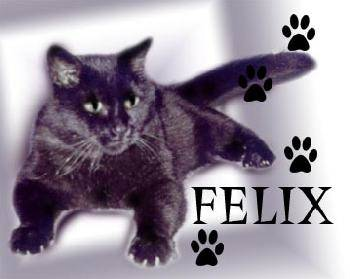

### Dogs
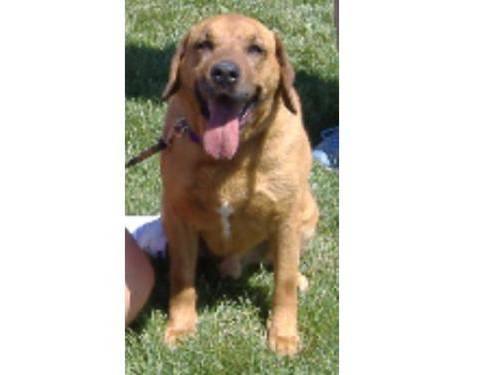

Using CNN, create deep learning model that can classify whether image contain dogs or cats (binary classification)

In [3]:
data_directories = {
    "train": "Pertemuan_7/cats_and_dogs_small/train",
    "valid": "Pertemuan_7/cats_and_dogs_small/validation"
}

datasets = {}

for name, directory in data_directories.items():
    datasets[name] = tf.keras.utils.image_dataset_from_directory(
        directory,
        color_mode='rgb',
        image_size=(256, 256),
        seed=SEED_VALUE,
    )

Found 2000 files belonging to 2 classes.


2023-11-11 23:13:52.753015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 23:13:52.822683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 23:13:52.822905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 23:13:52.830704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 23:13:52.830963: I tensorflow/compile

Found 1000 files belonging to 2 classes.


### Display Sample Images from the Dataset

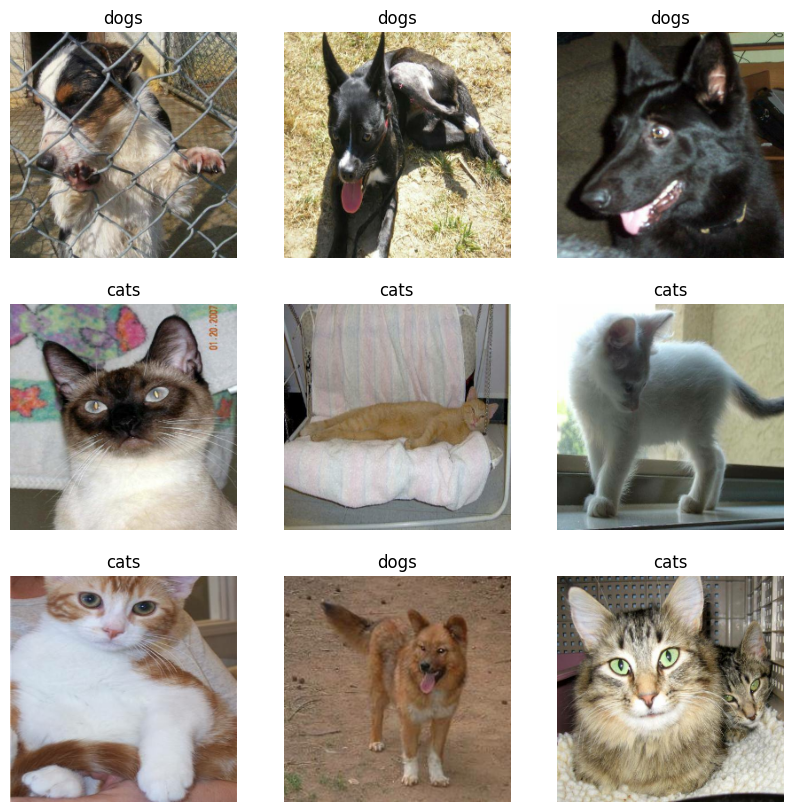

In [4]:
import matplotlib.pyplot as plt

class_names = datasets['train'].class_names

plt.figure(figsize=(10, 10))
for images, labels in datasets['train'].take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in datasets['train']:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = datasets['train'].cache().shuffle(SEED_VALUE).prefetch(buffer_size=AUTOTUNE)
val_ds = datasets['valid'].cache().prefetch(buffer_size=AUTOTUNE)

## Dataset and Training Configuration Parameters

Before we describe the model implementation and training, we’re going to apply a little more structure to our training process by using the dataclasses module in python to create simple DatasetConfig and TrainingConfig classes to organize several data and training configuration parameters. This allows us to create data structures for configuration parameters, as shown below. The benefit of doing this is that we have a single place to go to make any desired changes.

In [7]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 2
    IMG_HEIGHT:   int = 256
    IMG_WIDTH:    int = 256
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31 # how many training iteration performed, each iteration include all training data
    BATCH_SIZE:    int = 256 # how many data is used for training until it reach all training data
    LEARNING_RATE: float = 0.001 # how big the change in weight in each training iteration, bigger value may miss the optimal weight but converge quicker, and the opposite for smaller value

## Define the Convolutional Blocks for the CNN

In [8]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(DatasetConfig.NUM_CLASSES)
])

## Compile the Model

The next step is to compile the model, where we specify the optimizer type and loss function and any additional metrics we would like recorded during training. Here we specify RMSProp as the optimizer type for gradient descent, and we use a cross-entropy loss function which is the standard loss function for classification problems. We specifically use categorical_crossentropy since our labels are one-hot encoded. Finally, we specify accuracy as an additional metric to record during training. The value of the loss function is always recorded by default, but if you want accuracy, you need to specify it.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

## Create the Model

We can now create an instance of the model by calling the function above and use the summary() method to display the model summary to the console.

In [10]:
# Create the model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

## Train the Model

In [11]:
history = model.fit(train_ds,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=val_ds
                   )

Epoch 1/31


2023-11-11 23:13:59.182477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-11 23:14:04.127125: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561465423f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-11 23:14:04.127159: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-11 23:14:04.133714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-11 23:14:04.211083: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 13s 54ms/step - loss: 0.7370 - accuracy: 0.5430 - val_loss: 0.6821 - val_accuracy: 0.5450
Epoch 2/31
63/63 [==============================] - 2s 33ms/step - loss: 0.6530 - accuracy: 0.6115 - val_loss: 0.6246 - val_accuracy: 0.6370
Epoch 3/31
63/63 [==============================] - 2s 32ms/step - loss: 0.6123 - accuracy: 0.6630 - val_loss: 0.5897 - val_accuracy: 0.6820
Epoch 4/31
63/63 [==============================] - 2s 32ms/step - loss: 0.5565 - accuracy: 0.7180 - val_loss: 0.5923 - val_accuracy: 0.6710
Epoch 5/31
63/63 [==============================] - 2s 33ms/step - loss: 0.4484 - accuracy: 0.7900 - val_loss: 0.6363 - val_accuracy: 0.6880
Epoch 6/31
63/63 [==============================] - 2s 33ms/step - loss: 0.3432 - accuracy: 0.8480 - val_loss: 0.6704 - val_accuracy: 0.6820
Epoch 7/31
63/63 [==============================] - 2s 32ms/step - loss: 0.2196 - accuracy: 0.9085 - val_loss: 0.9296 - val_accuracy: 0.6970
Epoch 8/31
63/63 [=====

## Plot the Training Results

The function below is a convenience function to plot training and validation losses and training and validation accuracies. It has a single required argument which is a list of metrics to plot.

In [12]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

The loss and accuracy metrics can be accessed from the history object returned from the fit method. We access the metrics using predefined dictionary keys, as shown below.

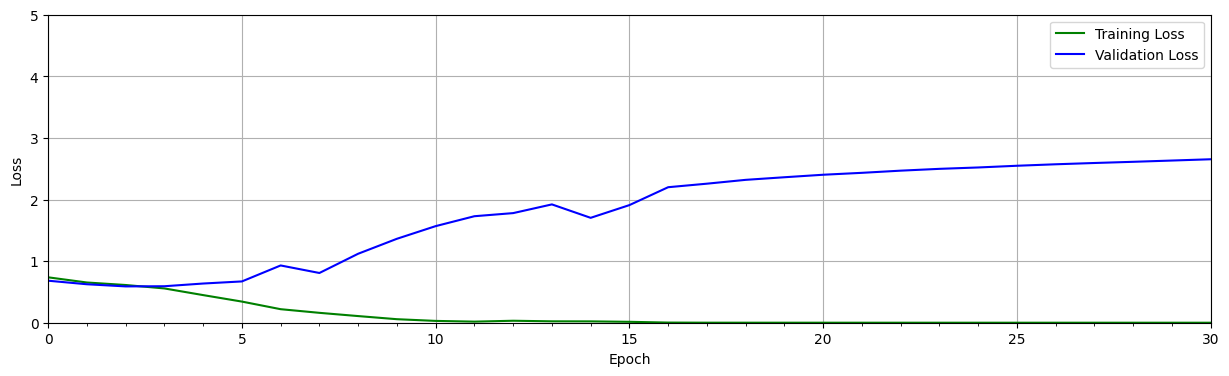

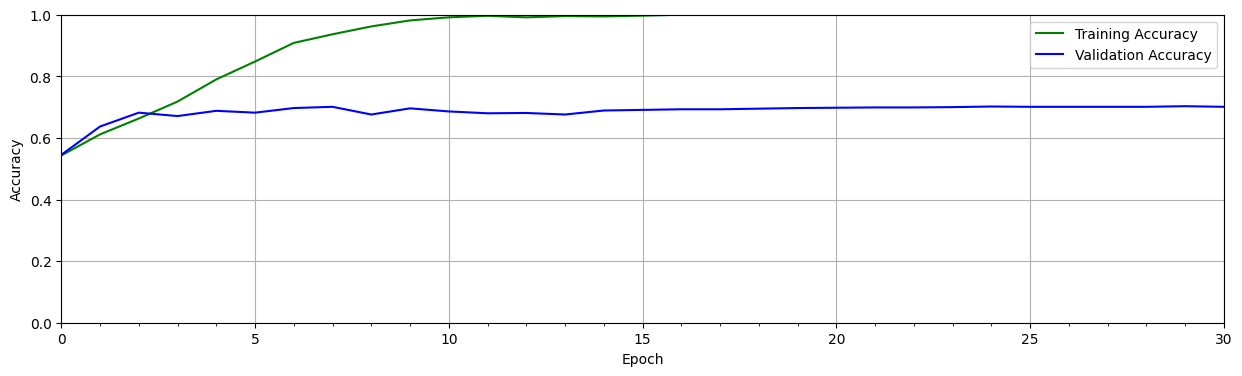

In [13]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

## Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [14]:
from tensorflow import keras

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(DatasetConfig.IMG_HEIGHT,
                                  DatasetConfig.IMG_WIDTH,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

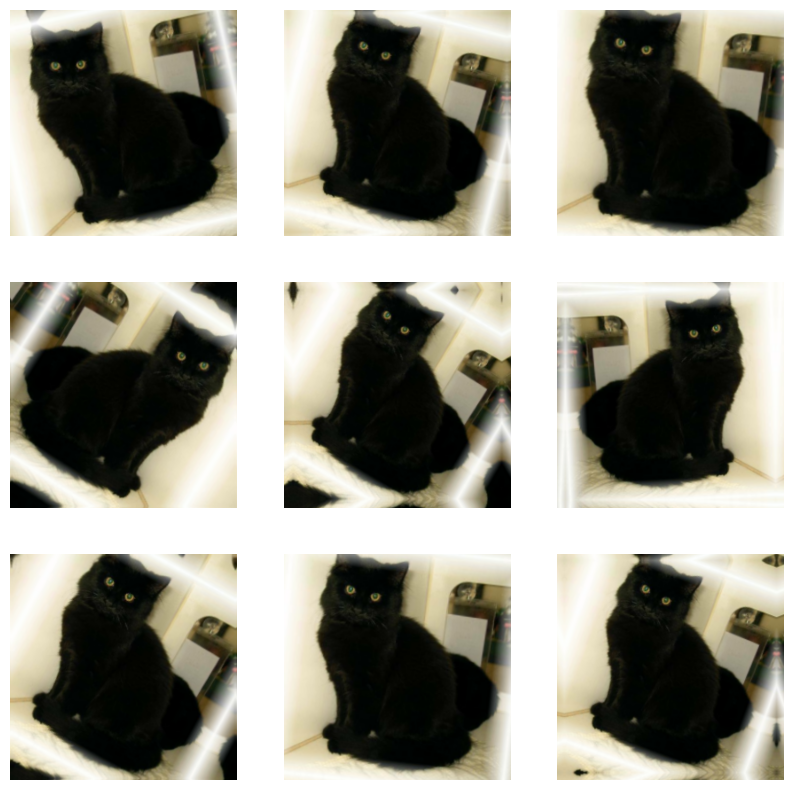

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(DatasetConfig.NUM_CLASSES, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [19]:
history = model.fit(train_ds,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=val_ds
                   )

Epoch 1/31


2023-11-11 23:15:12.673809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - 6s 54ms/step - loss: 0.7223 - accuracy: 0.5070 - val_loss: 0.6925 - val_accuracy: 0.5060
Epoch 2/31
63/63 [==============================] - 3s 44ms/step - loss: 0.6764 - accuracy: 0.5800 - val_loss: 0.7332 - val_accuracy: 0.5490
Epoch 3/31
63/63 [==============================] - 3s 44ms/step - loss: 0.6786 - accuracy: 0.5875 - val_loss: 0.6840 - val_accuracy: 0.5430
Epoch 4/31
63/63 [==============================] - 3s 44ms/step - loss: 0.6581 - accuracy: 0.5880 - val_loss: 0.6552 - val_accuracy: 0.6040
Epoch 5/31
63/63 [==============================] - 3s 44ms/step - loss: 0.6668 - accuracy: 0.6060 - val_loss: 0.6647 - val_accuracy: 0.5980
Epoch 6/31
63/63 [==============================] - 3s 44ms/step - loss: 0.6415 - accuracy: 0.6475 - val_loss: 0.6262 - val_accuracy: 0.6490
Epoch 7/31
63/63 [==============================] - 3s 44ms/step - loss: 0.6368 - accuracy: 0.6375 - val_loss: 0.6443 - val_accuracy: 0.6440
Epoch 8/31
63/63 [======

## Visualize training results
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

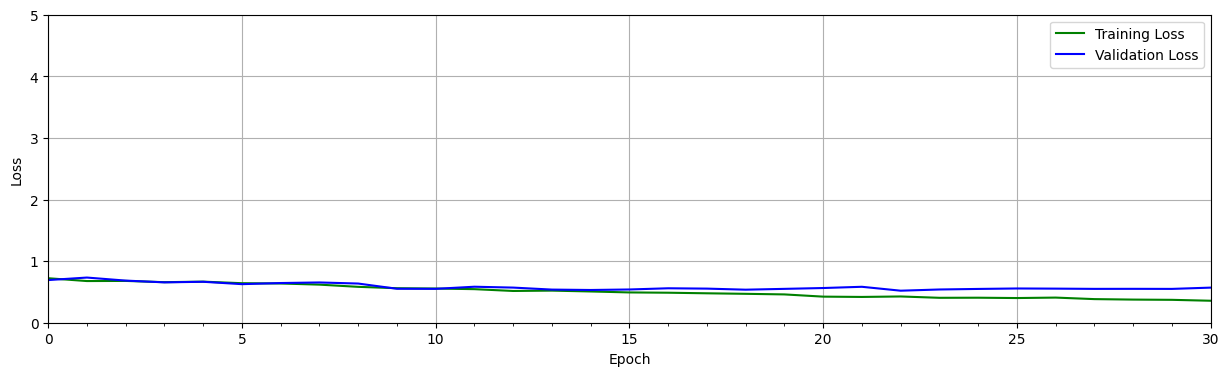

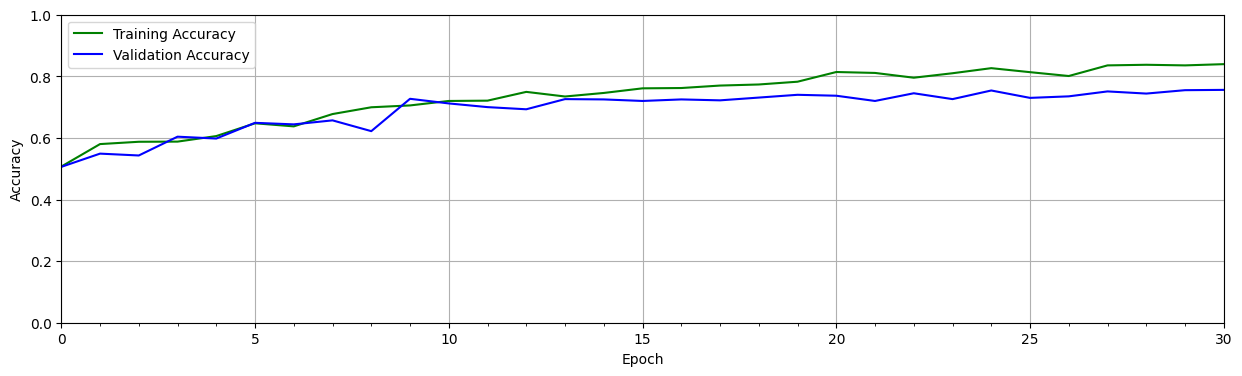

In [20]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
     
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## Model Evaluation
There are several things we can do to evaluate the trained model further. We can compute the model’s accuracy on the test dataset. We can visually inspect the results on a subset of the images in a dataset and plot the confusion matrix for a dataset. Let’s take a look at all three examples.

In [21]:
dataset_test = tf.keras.utils.image_dataset_from_directory(
    "Pertemuan_7/cats_and_dogs_small/test",
    color_mode='rgb',
    image_size=(256, 256),
    shuffle=False,
    seed=SEED_VALUE,
)

# Initialize an empty list to store the labels
y_test = []

# Iterate over the dataset
for images, labels in dataset_test:
    # Extend the y_test list with the labels from the current batch
    y_test.extend(labels.numpy())

# Convert the list to a numpy array
y_test = np.array(y_test)

Found 1000 files belonging to 2 classes.


## Evaluate the Model on the Test Dataset
We can now predict the results for all the test images, as shown in the code below. Here, we call the predict() method to retrieve all the predictions, and then we select a specific index from the test set and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

In [22]:
test_loss, test_acc = model.evaluate(dataset_test)
print(f"Test accuracy: {test_acc*100:.3f}")

32/32 [==============================] - 1s 16ms/step - loss: 0.6326 - accuracy: 0.7330
Test accuracy: 73.300


## Confusion Matrix
A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted labels from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). Generating a confusion matrix in TensorFlow is accomplished by calling the function tf.math.confusion_matrix(), which takes two required arguments: the list of ground truth labels and the associated predicted labels.

In [23]:
# Generate predictions for the test dataset.
predictions = model.predict(dataset_test)
 
# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

32/32 [==============================] - 1s 15ms/step


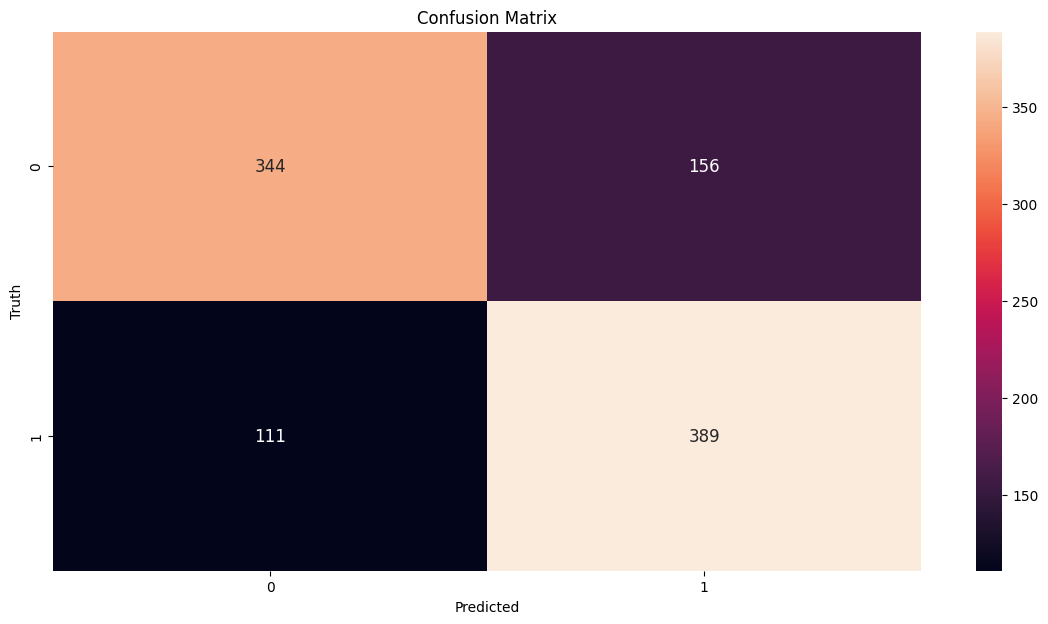

In [24]:
# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test, predictions=predicted_labels)
 
# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[14, 7])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [25]:
experiment_dir = "DogsAndCats"

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_dir)

experiment = mlflow.get_experiment_by_name(experiment_dir)
runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)
count = len(runs)

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from urllib.parse import urlparse

In [27]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    return accuracy, f1, recall, precision

In [28]:
if __name__ == "__main__":
    rand_seed = SEED_VALUE
    np.random.seed(SEED_VALUE)

    with mlflow.start_run(run_name=f"CNN_base", nested=True):
        # Test CNN Model on Test Data
        predictions = model.predict(dataset_test)
        y_pred = [np.argmax(i) for i in predictions]
        (accuracy, f1, recall, precision) = eval_metrics(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1 score", f1)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        
        mlflow.log_param("epochs", TrainingConfig.EPOCHS)
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("activation", "relu")
        mlflow.log_param("batch_size", TrainingConfig.BATCH_SIZE)
        mlflow.log_param("learning_rate", TrainingConfig.LEARNING_RATE)
        
        # Save the model in MLflow
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.keras.log_model(model, "model", registered_model_name=f"CNN_base")
        else:
            mlflow.keras.log_model(model, "model")

32/32 [==============================] - 0s 15ms/step


2023/11/11 23:16:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Accuracy: 0.733
F1 Score: 0.7444976076555024
Recall: 0.778
Precision: 0.7137614678899082
INFO:tensorflow:Assets written to: /tmp/tmp8283eb8j/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp8283eb8j/model/data/model/assets
/home/randi_eka/anaconda3/envs/huggingface/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'CNN_base' already exists. Creating a new version of this model...
2023/11/11 23:16:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CNN_base, version 2
Created version '2' of model 'CNN_base'.


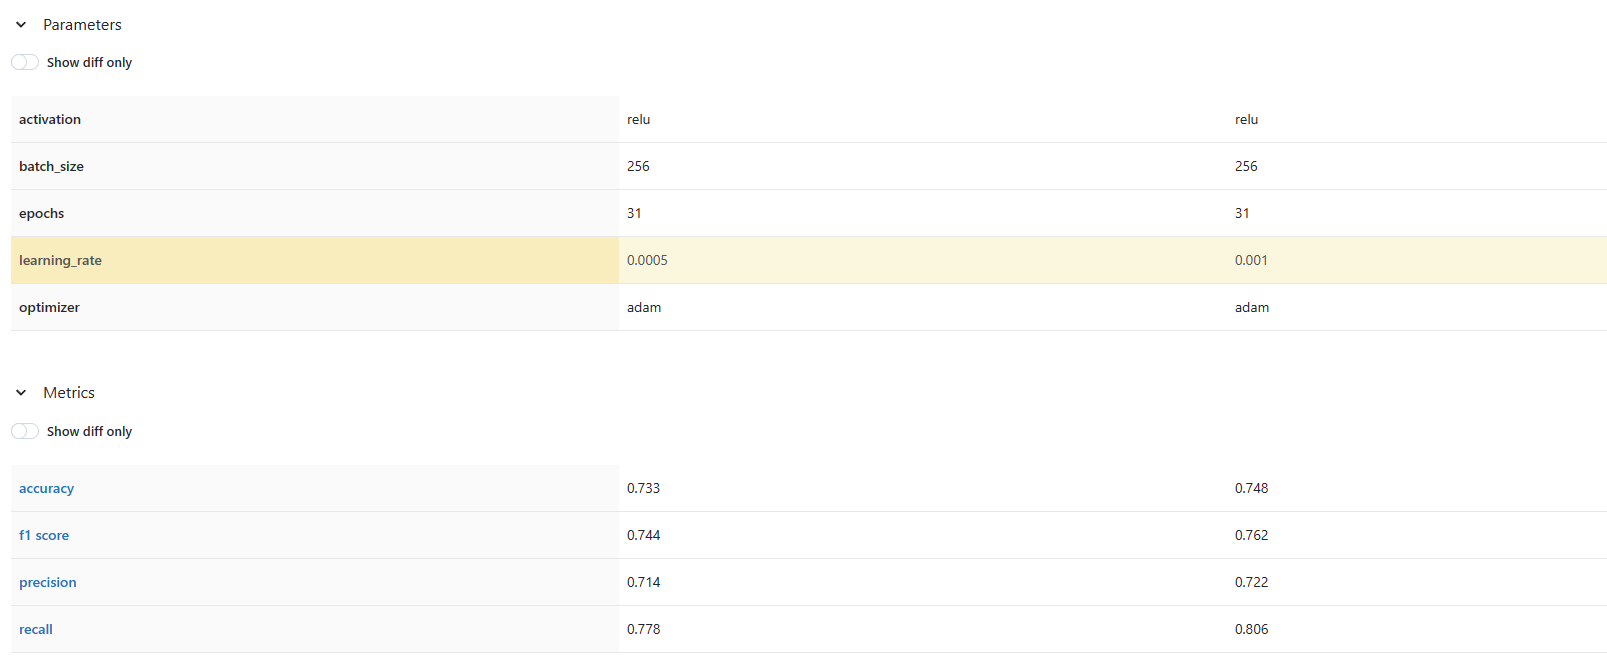

Lets learn about how to interpret the metrics

1 - Accuracy is suitable with balanced dataset when there are an equal number of observations in each class which isn’t common in real-life problems.

2 - Precision is important when the cost of false positives is high.

3 - Recall is important when the cost of false negatives is high.

4 - F1 score considers both the precision and recall.

Based on two attemps only, using learning rate 0.001 yield better merics compared to 0.005 across all metrices

## Predict on new data
Use your model to classify an image that wasn't included in the training or validation sets.

1/1 [==============================] - 0s 58ms/step
This image most likely belongs to dogs with a 95.71 percent confidence.


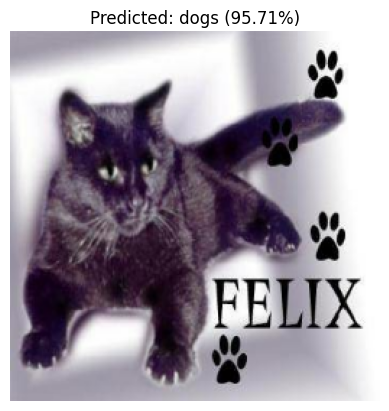

In [29]:
# Take one batch of images from the test dataset
for images, labels in dataset_test.take(1):
    # Predict the first image in the batch
    predictions = model.predict(images)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # Display the image along with the predicted label
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Predicted: {class_names[np.argmax(score)]} ({100 * np.max(score):.2f}%)")
    plt.axis('off')
    plt.show()

## Use TensorFlow Lite
TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

## Convert the Keras Sequential model to a TensorFlow Lite model
To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

In this example, take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model:

In [30]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9ac5zhdv/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ac5zhdv/assets
2023-11-11 23:16:57.075451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-11 23:16:57.075490: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-11 23:16:57.076656: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9ac5zhdv
2023-11-11 23:16:57.078217: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-11 23:16:57.078227: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9ac5zhdv
2023-11-11 23:16:57.081728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-11 23:16:57.082830: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-11 23:16:57.145892: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

## Run the TensorFlow Lite model
You can access the TensorFlow Lite saved model signatures in Python via the tf.lite.Interpreter class.

Load the model with the Interpreter:

In [31]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):

In [32]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called serving_default. In addition, the name of the 'inputs' is 'sequential_1_input', while the 'outputs' are called 'outputs'. You can look up these first and last Keras layer names when running Model.summary, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows:

In [33]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as dataset_test. Now, pass it to the first argument (the name of the 'inputs') of the loaded TensorFlow Lite model (predictions_lite), compute softmax activations, and then print the prediction for the class with the highest computed probability.

This image most likely belongs to dogs with a 95.71 percent confidence.


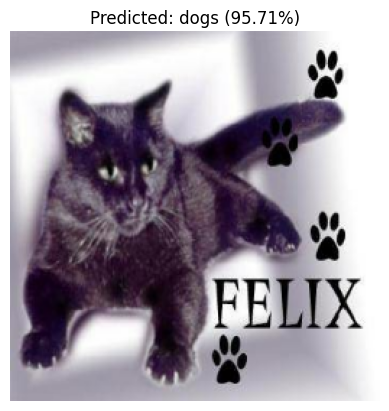

In [34]:
# Take one batch of images from the test dataset
for images, labels in dataset_test.take(1):
    # Predict the first image in the batch
    predictions_lite = classify_lite(sequential_1_input=images)['outputs']
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # Display the image along with the predicted label
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Predicted: {class_names[np.argmax(score)]} ({100 * np.max(score):.2f}%)")
    plt.axis('off')
    plt.show()

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [35]:
print(np.max(np.abs(predictions - predictions_lite)))

0.0038819313


## Conclusion
This tutorial showed how to train a model for image classification on Dogs and Cats Small dataset, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.